# Data downloading and pre-processing

This notebook covers the steps we took to download lightcurves from multiple different sources, how we processed the data, and how we combined and formatted the data. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.table import Table
from pathlib import Path
from astropy.coordinates import SkyCoord
from astroquery.mast import Catalogs
import pandas as pd
from astropy.table import vstack
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u

We start with a list of TIC ID's of sources we are interested in, which are a list of systems that are candidates for hosting circumbinary planets.

In [5]:
# Create a list of targets
tic_ids = [81741369, 293225466, 274182408, 457579488, 124282654, 286310830, 51629874, 123951716, 396170777, 139699256, 56023695, 292357653, 82893635, 196989952, 146204045, 283651681, 61656788, 444544588, 252497283, 167699456, 343127696, 253270207, 158330804, 115396972, 399127035, 355503224, 95622298, 64366964, 198242678, 84546771, 291751499, 167756615, 441496809, 165615442, 121092916, 342356517]

We also want to get a list of WASP and KELT lightcurves and metadata for these same TIC sources. These were downloaded from their respective databases for [KELT](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblSearch/nph-tblSearchInit?app=ExoTbls&config=kelttimeseries) and [WASP](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblSearch/nph-tblSearchInit?app=ExoTbls&config=superwasptimeseries). We can then read in our metadata tables and use it to link our TESS, KELT, and WASP data together.

Due to the way the search result comes back, it is possible to get duplicates or multiple matches, so we ensure that we filter these out too such that our resulting table contains only unique entries.

In [6]:
# Read in the metadata tables
kelt_catalog = Table.read('Data/KELT/kelttimeseries_2026.01.06_21.24.27.csv', format='csv', comment='#')
wasp_catalog = Table.read('Data/WASP/superwasptimeseries_2026.01.06_21.22.05.csv', format='csv', comment='#')

# Filter the KELT table to only contain unique entries
kelt_df = pd.DataFrame(kelt_catalog.as_array())
kelt_df = kelt_df.sort_values(by="proc_type", key=lambda s: s != "tfa").drop_duplicates(subset=["kelt_sourceid", "bjdstart"], keep="first")
kelt_catalog = Table.from_pandas(kelt_df)

# Filter the WASP data to drop duplicates and only take the closest match following a cone search
wasp_df = pd.DataFrame(wasp_catalog.as_array())
wasp_df = wasp_df.assign(name_user=lambda d: d["name_user"].str.strip()).loc[lambda d: d["dist_user"] == d.groupby("name_user")["dist_user"].transform("min")].drop_duplicates(subset=["sourceid", "hjdstart"])
wasp_catalog = Table.from_pandas(wasp_df)

Since both of these tables contain a name_user column that returns our TIC ID's we can uniquely map each lightcurve in WASP and KELT to our TESS lightcurves, compiling our data into a combined list of lightcurves per system.

Note since lightkurve doesn't require TIC IDs as inputs, it would be possible to give it a variety of different input (i.e. coordinates). This would also change the process for downloading WASP, KELT, or other data, however there is typically quite wide functionality for source selection in these tables.

In [7]:
# Create a list to store all of our lightcurve lists in
sources_list = []
kelt_folder = Path("Data/KELT")
wasp_folder = Path("Data/WASP")

for id in tic_ids:
    
    source_list = [] # Create one list per source
    id_str = f'TIC {id}' 

    # TESS Data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    search_result = lk.search_lightcurve(id_str, mission = 'TESS', author = 'QLP').download_all() # QLP is the best quality/quantity tradeoff we have
    for tess_lc in search_result:
        source_list.append(tess_lc)
    print(f'TESS Data appended for {id_str}') # There will always be TESS data for our sources as we got our candidate list from TESS data.

    # KELT Data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    kelt_id = kelt_catalog['kelt_sourceid'][kelt_catalog['name_user'] == id_str] # Mask our metadata table to look for a match
    if len(kelt_id) > 0:
        kelt_index = str(kelt_id[0])
        matches = list(kelt_folder.glob(f"{kelt_index}*.tbl")) # Search for matches in our folder containing the KELT lightcurves
        kelt_lc = Table.read(matches[0], format='ascii')
        source_list.append(kelt_lc)
        print(f'KELT Data found for {id_str}')
    else:
         print(f'No KELT Data found for {id_str} :c')

    # WASP Data ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    wasp_id = wasp_catalog['sourceid'][wasp_catalog['name_user'] == id_str]
    if len(wasp_id) > 0:
        wasp_index = str(wasp_id[0]).replace(" ", "_")
        matches = list(wasp_folder.glob(f"{wasp_index}*.tbl"))
        wasp_lc = Table.read(matches[0], format='ascii')
        source_list.append(wasp_lc)
        print(f'WASP Data found for {id_str}')
    else:
        print(f'No WASP Data found for {id_str} :c')

    # Dump list of lcs into our big list
    sources_list.append(source_list)
    print()

TESS Data appended for TIC 81741369
KELT Data found for TIC 81741369
No WASP Data found for TIC 81741369 :c

TESS Data appended for TIC 293225466
No KELT Data found for TIC 293225466 :c
No WASP Data found for TIC 293225466 :c

TESS Data appended for TIC 274182408
No KELT Data found for TIC 274182408 :c
WASP Data found for TIC 274182408

TESS Data appended for TIC 457579488
No KELT Data found for TIC 457579488 :c
No WASP Data found for TIC 457579488 :c

TESS Data appended for TIC 124282654
No KELT Data found for TIC 124282654 :c
WASP Data found for TIC 124282654

TESS Data appended for TIC 286310830
No KELT Data found for TIC 286310830 :c
No WASP Data found for TIC 286310830 :c

TESS Data appended for TIC 51629874
No KELT Data found for TIC 51629874 :c
No WASP Data found for TIC 51629874 :c

TESS Data appended for TIC 123951716
KELT Data found for TIC 123951716
No WASP Data found for TIC 123951716 :c

TESS Data appended for TIC 396170777
No KELT Data found for TIC 396170777 :c
No WASP D

Our first pre-processing step is to take note of TESS's quality flag, and remove any low quality data from our lightcurves. There was no such flag that was visible in the KELT or WASP data, however other datasets may have quality flags to indicate poor quality data that should be removed before data analysis.

In [8]:
# Loop over all sources and remove any low quality data from TESS lightcurves
for source in sources_list:
    for lc in source:
        if type(lc) == lk.lightcurve.TessLightCurve:
            quality_mask = lc['quality'] == 0
            lc = lc[quality_mask]   

Now that we have all of these lists, we need to homogenise the data to make it possible to use in any meaningful way. At current, each dataset uses its own formats for flux and time, so they cannot be directly compared or analysed together. To do so, we want to median divide our lightcurves such that the baseline flux is ~1, and convert all of our times into BJD. This is done using 3 functions, one for each different type of lightcurve.

Our final data should be in the format of time, flux, and flux error. We also add a column that contains the providence of the data (TESS, WASP, or KELT) and the TIC ID of the source.

In [9]:
def tess_to_table(lc, tic_str): # Convert our TESS data into a universal format

    time_btjd = lc.time.value
    flux = lc.flux.value # Already median normalised to 1
    flux_err = lc.flux_err.value

    # Convert BTJD to BJD
    time = time_btjd + 2457000

    tess_table = Table([time, flux, flux_err, ['TESS']*len(lc), [tic_str]*len(lc)], 
                       names=['time', 'flux', 'flux_err', 'source', 'tic_id'])
    
    return tess_table

In [10]:
def wasp_to_table(lc, tic_str): # Convert WASP data into a universal format

    # Observatory locations used to correct to  from HJD
    wasp_north = EarthLocation(lat=28.76*u.deg, lon=-17.89*u.deg, height=2326*u.m)
    wasp_south = EarthLocation(lat=-32.38*u.deg, lon=20.81*u.deg, height=1798*u.m)

    time_hjd = lc['HJD']
    flux_raw = lc['FLUX2']
    flux_err_raw = lc['FLUX2_ERR']

    # Normalise our flux values
    flux = flux_raw / np.nanmedian(flux_raw)
    flux_err = flux_err_raw / np.nanmedian(flux_raw)

    # Convert time to BJD
    ra = float(wasp_catalog[wasp_catalog['name_user'] == tic_str]['ra'][0])
    dec = float(wasp_catalog[wasp_catalog['name_user'] == tic_str]['dec'][0])
    coord = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)

    # Determine which site the observation came from (this isn't rigorous but unfortunately no clear flag for this information)
    if dec >= -20: # Northern Observatory
        loc = wasp_north
    
    else: # Southern Observatory
        loc = wasp_south

    hjd_temp = Time(time_hjd, format='jd', scale='utc', location=loc)
    bjd = hjd_temp.tdb + hjd_temp.light_travel_time(coord) # Correct for the location of the observatory
    time = bjd.value


    wasp_table = Table([time, flux, flux_err, ['WASP']*len(lc), [tic_str]*len(lc)], 
                       names=['time', 'flux', 'flux_err', 'source', 'tic_id'])
    
    return wasp_table

In [11]:
def kelt_to_table(lc, tic_str): # Convert KELT data to a universal format

    time = lc['TIME'] # Already in BJD
    mag = lc['MAG']
    mag_err = lc['MAG_ERR']

    # Convert Mag --> Flux
    flux_raw = 10**(-0.4 * (mag))
    flux_err_raw = flux_raw * np.log(10) * 0.4 * mag_err

    # Normalise flux values
    flux = flux_raw / np.nanmedian(flux_raw)
    flux_err = flux_err_raw / np.nanmedian(flux_raw)

    kelt_table = Table([time, flux, flux_err, ['KELT']*len(lc), [tic_str]*len(lc)], 
                       names=['time', 'flux', 'flux_err', 'source', 'tic_id'])
    
    return kelt_table

Now that we have a function to process each of our lightcurves, we can pass our lists through our functions and stack everything together to create one long lightcurve per source. Note my method for determining the origin of the data is to check for unique fingerprints such as column names or object types. This is prone to breaking if multiple formats use the same data, so you may need to adjust this part if you add a lot of new datasets.

In [12]:
# Normalise and stack different lightcurves to create one per source
combined_lcs = []

for source, tic_id in zip(sources_list, tic_ids):

    source_tables = []
    tic_str = f'TIC {tic_id}'

    for lc in source:

        if type(lc) == lk.lightcurve.TessLightCurve: # Uniquely identifies our TESS lightcurves
            table = tess_to_table(lc, tic_str)
            source_tables.append(table)
            
        elif 'HJD' in lc.colnames: # Identifies our WASP data
            table = wasp_to_table(lc, tic_str)
            source_tables.append(table)

        elif 'TIME' in lc.colnames: # Identifies our KELT data
            table = kelt_to_table(lc, tic_str)
            source_tables.append(table)

        else: # Return a warning that there is some foreign or unaccounted for data/format in our lists
            print(f'Unknown lightcurve type detected for {tic_str}')

    full_table = vstack(source_tables) # Stack to create a single lightcurve per source
    combined_lcs.append(full_table)

The warnings we get are due to the combination of different units being used (magnitudes vs fluxes). Luckily, this issue doesn't bother us since we converted our magnitudes and fluxes into a non-dimensional flux.

Next, we do some quick processing by removing flares/high flux outliers. We want to keep our filtering minimal since we want to keep the vast majority of our data, but excessive signal above the baseline flux will never be meaningful for our eclipse fitting. We will also get rid of any of our sources that contain no KELT or WASP data, since we can't learn anything new about these systems without additional data.


In [15]:
lightcurves_clipped = []

for lc in combined_lcs:

    std = np.nanstd(lc['flux'])
    clip_mask = 1 + std

    lc_clipped = lc[lc['flux'] <= clip_mask] # Remove anything more than 1 sigma above the baseline flux (flares)
    lightcurves_clipped.append(lc_clipped)

In [16]:
lightcurves_nontess = []

for lc in lightcurves_clipped:
    if len(lc[lc['source'] == 'TESS']) < len(lc): # Check if there is any data from WASP or KELT
        lightcurves_nontess.append(lc)

To be able to do any analysis of the eclipses, it's helpful to know the period and phase of our sources. The periods I use here were independently measured, so we can just append these onto our lightcurves. We can then just divide by the relevant period to get our phases out.

In [17]:
# Read in a table that contains updated and accurate periods for each source
periods = Table.read('Data/perturber_candidate_periods.txt', format='csv')

In [18]:
# Add up to date periods and errors
lightcurves_with_periods = []

for lc in lightcurves_nontess:

    # Pull out the period data from our table
    tic_id = lc[0]['tic_id']
    tic_id = str(tic_id).replace(' ', '')
    period_row = periods[periods['TICID'] == tic_id]

    if len(period_row) == 0:
        print(f'No period found for {tic_id}')
        continue  # skip if no matching period

    # Extract scalar values
    p_period_val = period_row['PrimaryP'][0]
    p_period_err_val = period_row['PrimaryP_Err'][0]
    s_period_val = period_row['SecondaryP'][0]
    s_period_err_val = period_row['SecondaryP_Err'][0]

    # Fill a column with the same value for every row
    nrows = len(lc)
    lc['p_period'] = [p_period_val]*nrows
    lc['p_period_err'] = [p_period_err_val]*nrows
    lc['s_period'] = [s_period_val]*nrows
    lc['s_period_err'] = [s_period_err_val]*nrows

    lightcurves_with_periods.append(lc)

In [19]:
# Add phases for both periods
for lc in lightcurves_with_periods:

    lc['p_phase'] = ((lc['time'] - lc['time'][0]) / lc['p_period'])%1 
    lc['s_phase'] = ((lc['time'] - lc['time'][0]) / lc['s_period'])%1

# Account for some cases where an eclipse wrapped over the 1 --> 0 phase gap
lightcurves_with_periods[6]['p_phase'] = (lightcurves_with_periods[6]['p_phase'] + 0.2) % 1
lightcurves_with_periods[6]['s_phase'] = (lightcurves_with_periods[6]['s_phase'] + 0.2) % 1

lightcurves_with_periods[8]['p_phase'] = (lightcurves_with_periods[8]['p_phase'] - 0.1) % 1
lightcurves_with_periods[8]['s_phase'] = (lightcurves_with_periods[8]['s_phase'] - 0.1) % 1

lightcurves_with_periods[9]['p_phase'] = (lightcurves_with_periods[9]['p_phase'] + 0.2) % 1
lightcurves_with_periods[9]['s_phase'] = (lightcurves_with_periods[9]['s_phase'] + 0.2) % 1

One final thing we can do before saving our new lightcurves is to check out how they look by plotting them. While this step isn't necessary, it's always good to appreciate your work! After plotting, we can see that our baseline is extended a lot for many of these sources, which could make us more sensitive to long term trends and precession given the data is of an acceptable quality.

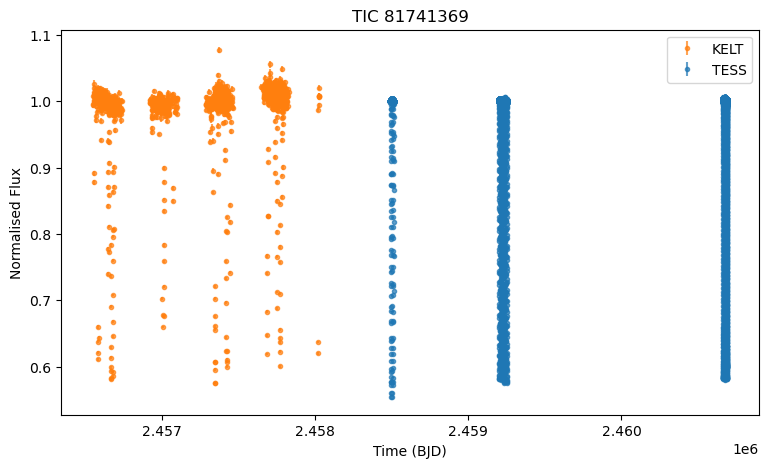

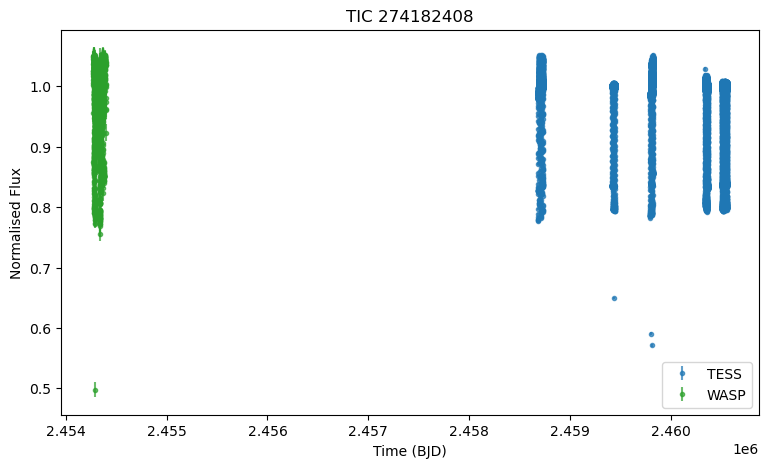

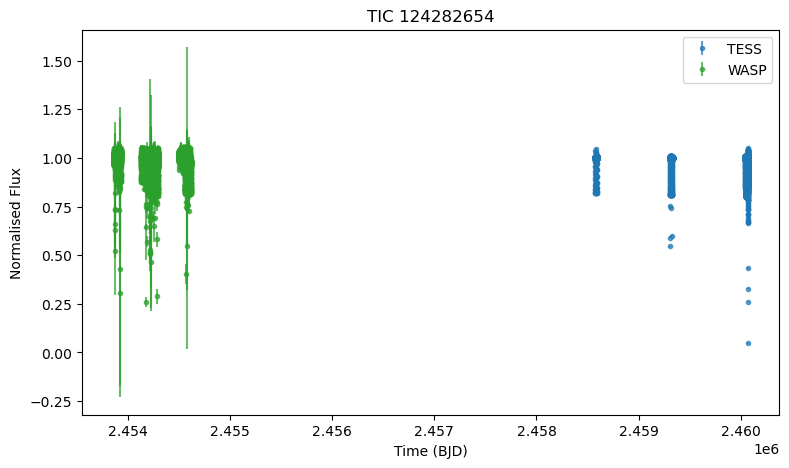

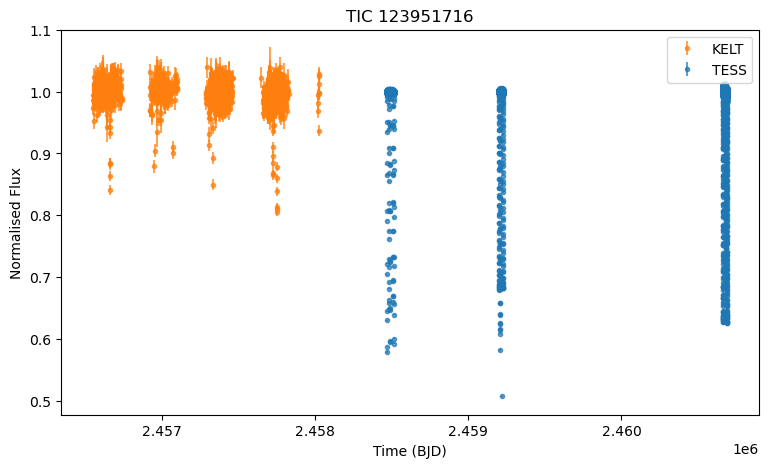

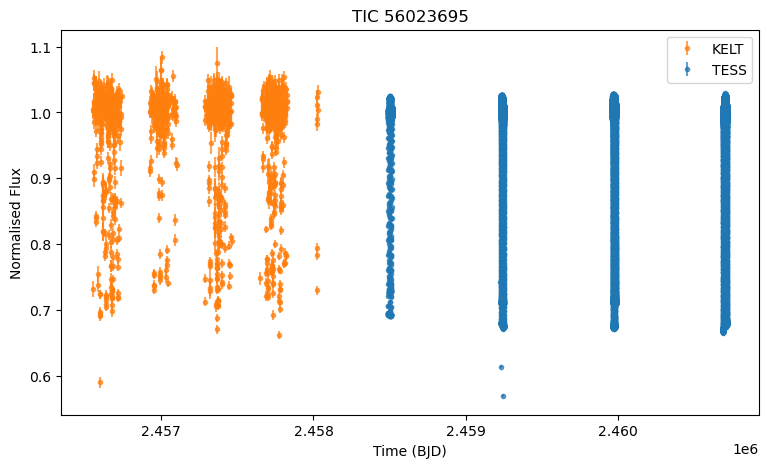

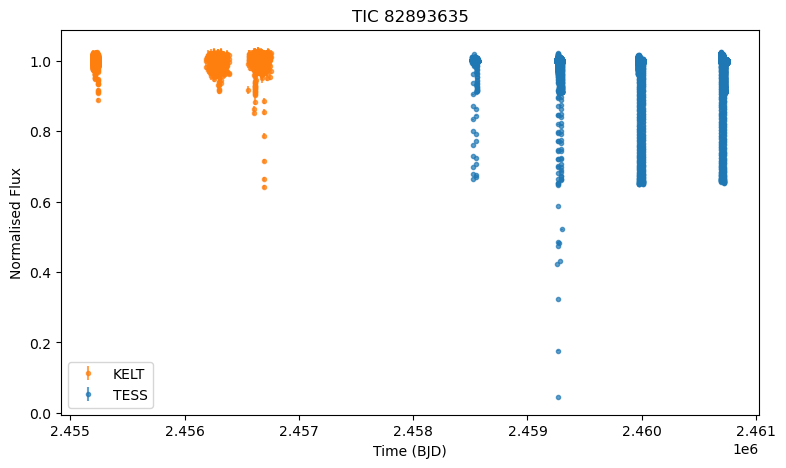

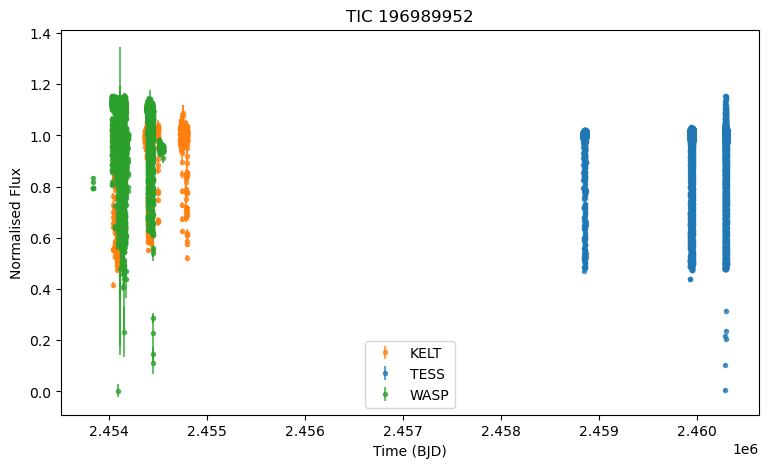

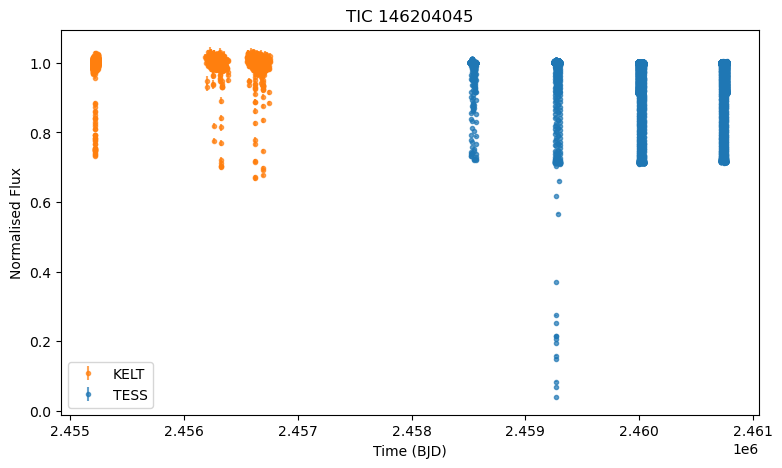

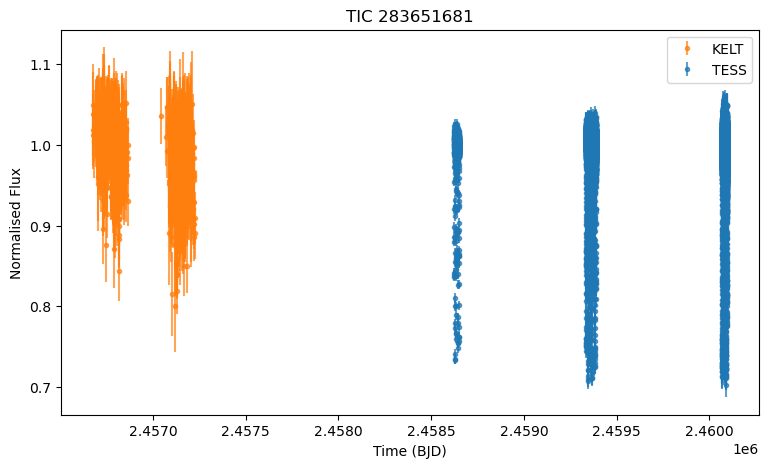

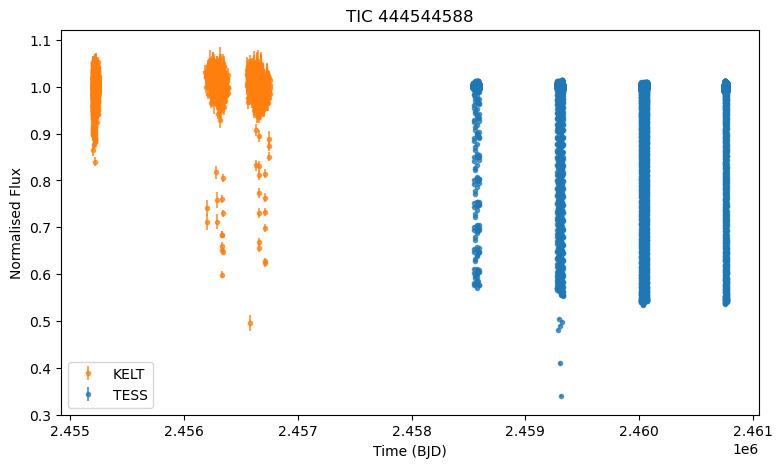

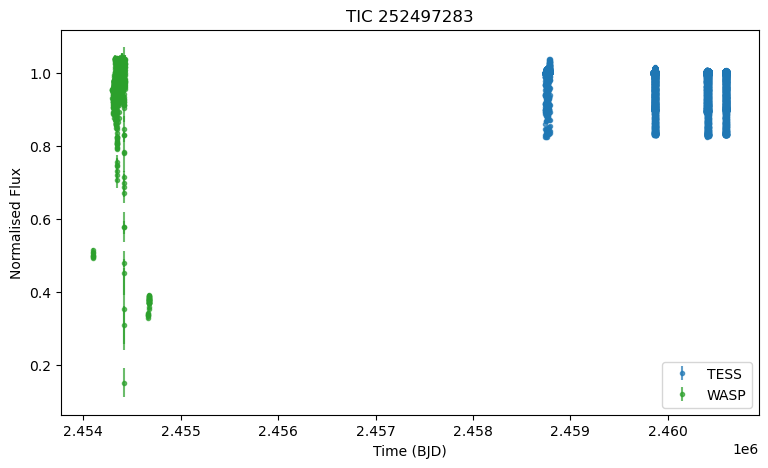

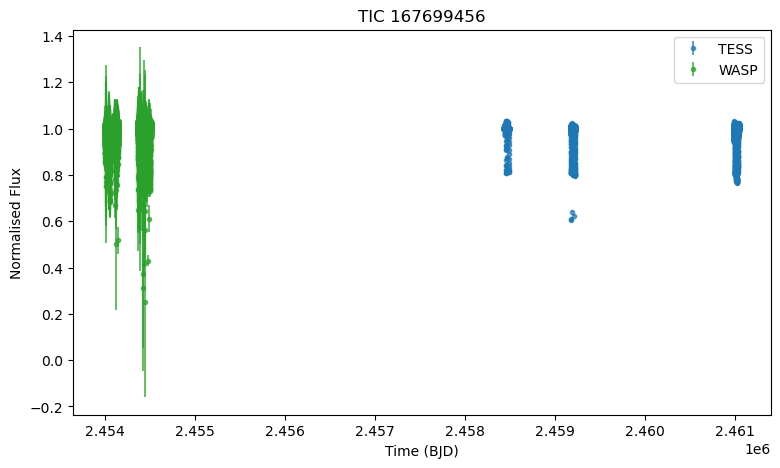

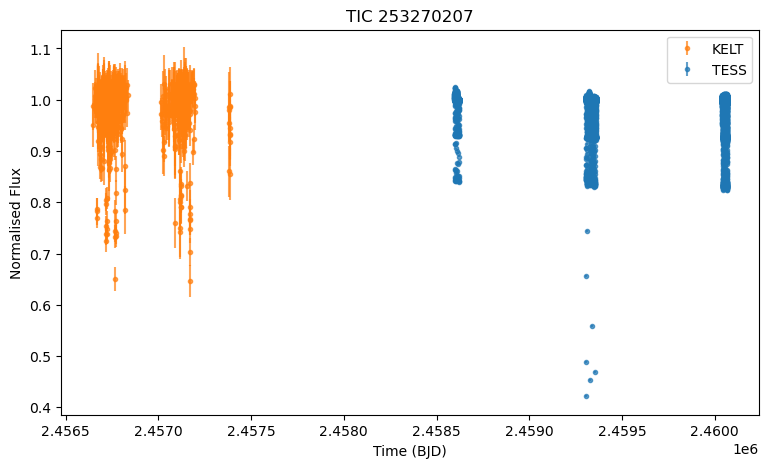

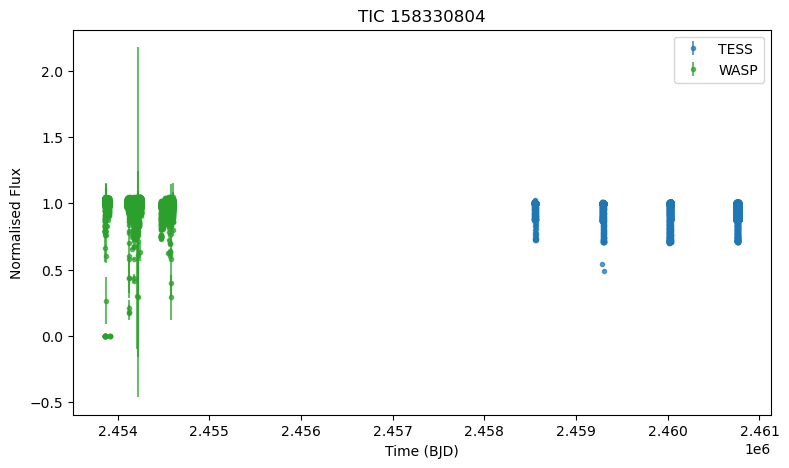

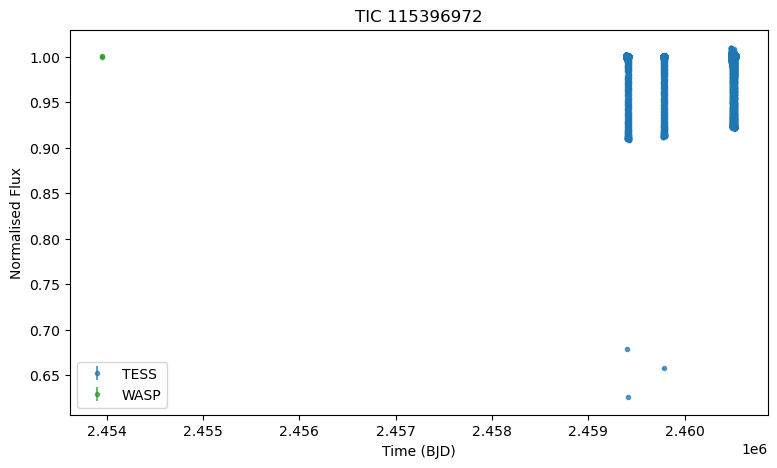

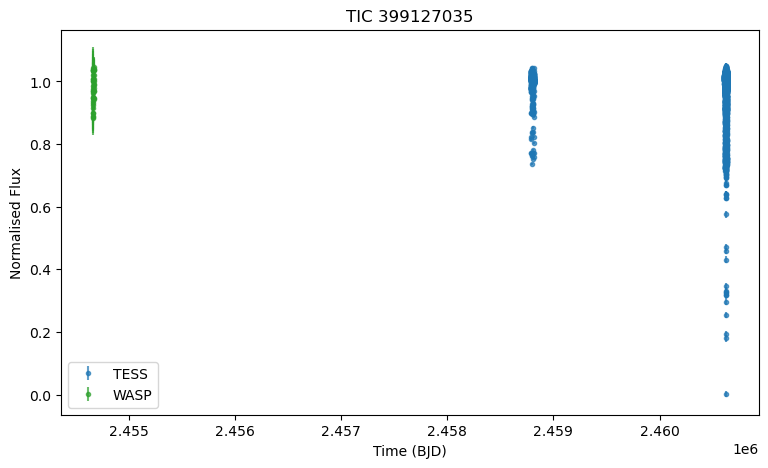

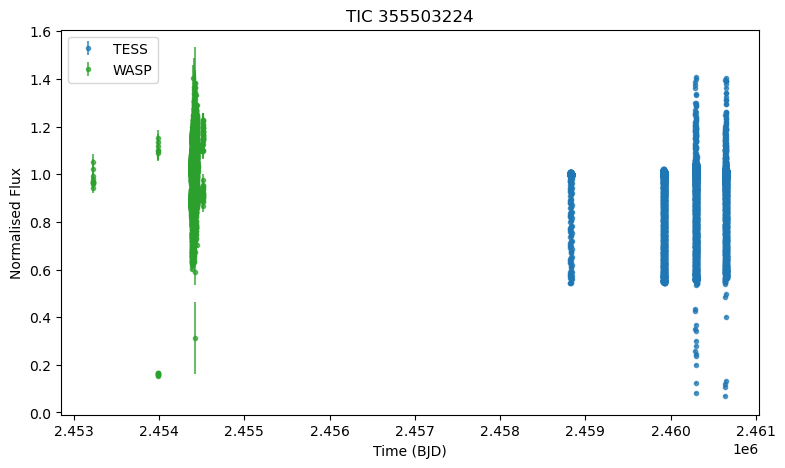

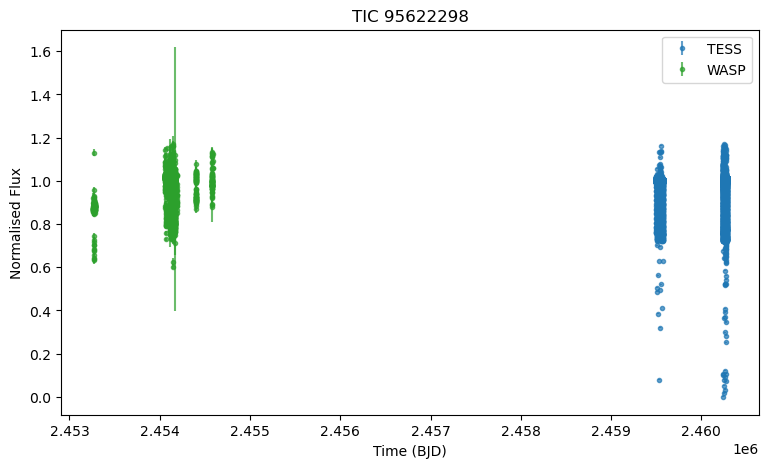

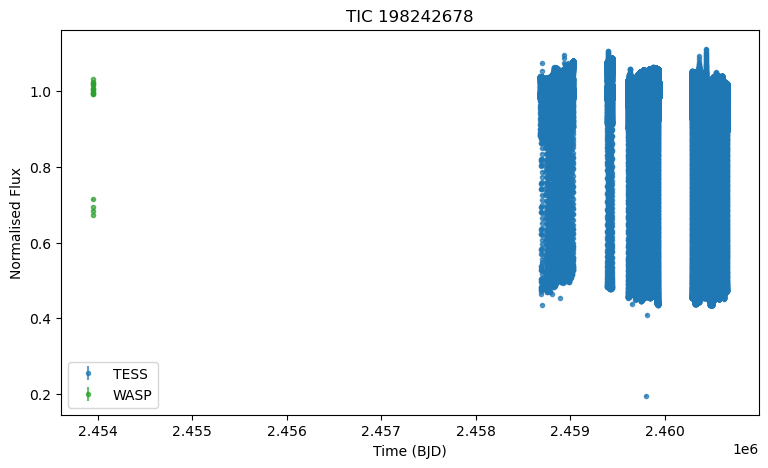

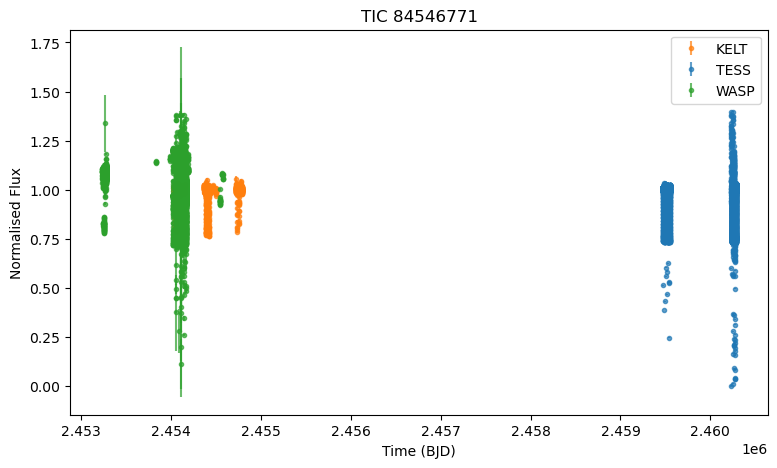

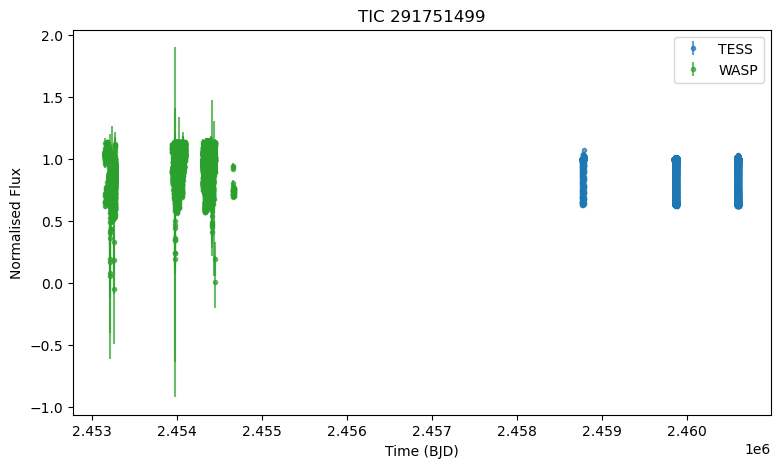

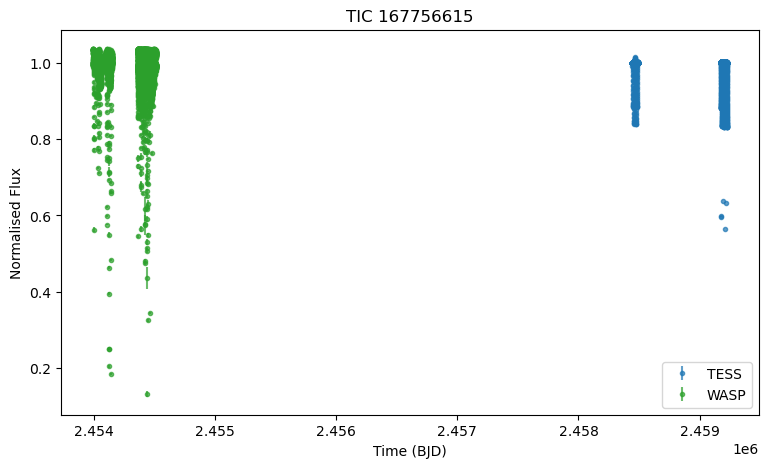

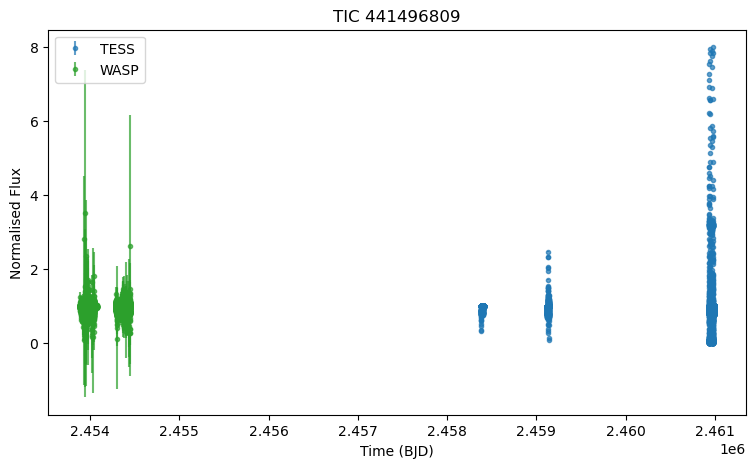

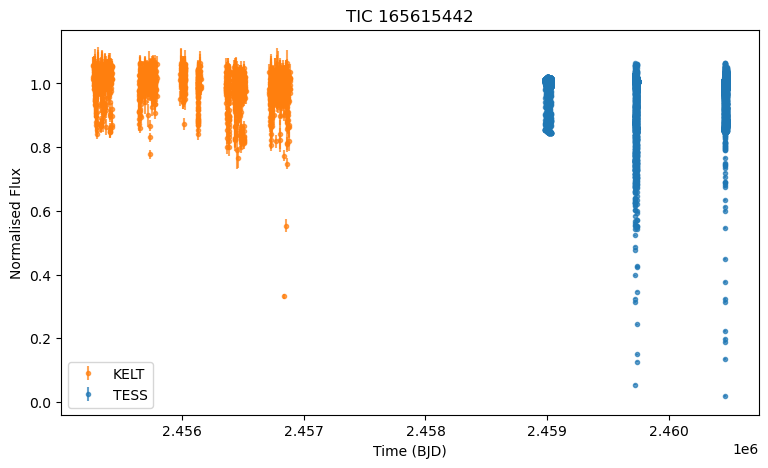

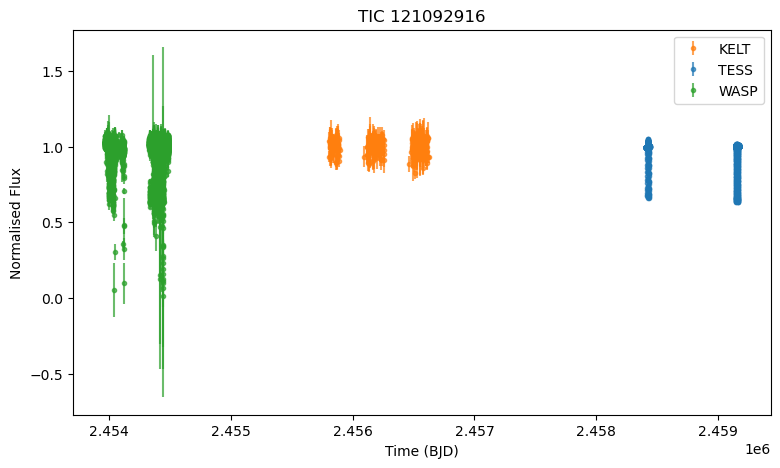

In [20]:
# Define fixed colors for each mission
color_map = {'TESS': 'tab:blue', 'KELT': 'tab:orange', 'WASP': 'tab:green'}

for lc in lightcurves_with_periods:
    plt.figure(figsize=(9,5))
    
    sources = np.unique(lc['source'])
    for s in sources:
        mask = lc['source'] == s
        plt.errorbar(lc['time'][mask],  lc['flux'][mask], yerr=lc['flux_err'][mask], fmt='.', color=color_map.get(s), label=s, alpha=0.7)
    
    plt.legend()
    plt.xlabel("Time (BJD)")
    plt.ylabel("Normalised Flux")
    plt.title(lc['tic_id'][0])
    plt.show()

Lastly, let's save our lightcurves so we can use them for future notebooks

In [28]:
# Specify location to save data
outdir = Path("Data/combined_lightcurves")
outdir.mkdir(exist_ok=True)

# Save each lightcurve as a csv file
for  lc in lightcurves_with_periods:
    tic_id = lc[0]['tic_id']
    filename = outdir / f"{tic_id}.csv"
    lc.write(filename, format="csv", overwrite=True)